In [33]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T195801Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44664a13253e11cf714034c64d2d28aab24cc994689b1ed89561caf598f2c1f5f0f3ce6d91a2d879fb4cac3ebb727c3a4ac64f208b40fd5fc92312772c5524275f93e758dd526790f3d2d65be5a746e2b2db35b9791cc1c03e70c52b4e9e1073756b65540a8cd380d4d53df40ef77794f240069829868e3f928c4ce399ad7cc4f69d120894332b6d08d538fba72775384e4f83ad082430873a986cfb6c2e8a2f19a92c57325ce0e5954967adf8766689e6306ac0f1459ed3e952b25ae105c0fcc7346b6e64fc8043a6f4cc360196664073eb707aa4d058439c8f0bf23df02879f6e3848dd9a3405cc2a953612efc75093790c39c286ea25133271752cfd513ea,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T195801Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae10011ad5c710192f65a03d85f0a207cf7ab796b4b74b932f2584c8c05b57b53a24ef06eb9d1c40090393bd8c92cde2241ce756f19e57d5eee71b4ca94e95cbdedbd7a360fa080b571e0b42bb174f130091aa1f92f3fc52091423c35b5478e7f34698a22e6512572145d7121081c5298e2083e37e7ba2ef4eed196c39a4beacd15a262bfcdc448ff8868398a0252425f6ade31521886b4546b8395deb16b45ec74a9a65bffe21607f82b486a9af176e8a48cec19a64d44ddeb890c1d1f76cb97eb8277500b1937ad5eee74287f5201e43430dc7373b419da62048064f94f1d4a0eab1f30802f5a2a9b3da5ef4c73144e38c07d585a14eae66e58901b8def445,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T195801Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4b44794bed0f895cfe891f1edfd036dc5b5c755672949028e47c7d14dd2d595db35e220dd98cf85977d4025093ed610107a0eb33a61dfe9578beb7684aa55c09272bf1c0c19f0748dadc3fb487bf2e7fa662fed01af6fb735aa6725d97ddb0e3ff19fb9167a99e1cc57147d2f4dc6a1b5c6cbbb4574f7878107bd7bff6d954a6f43e30314d1b218938a748b96c7729172e4a381b3f93f847066049a30689960fcc581fdaeaad7f9b3dcd0f2b451357903b0183660e301116e1a638f6e579703d457bde542b6f762ff4bd0ae089a5cf6393c399604f22be97829184b177f1a4e8b64a2115d7f0f7319d3728dfe272e3c76eae4a8ac252db0f5de29fd569b63a30,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T195801Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5522bd80acb6e344874398c514ca2c2b09812e9b06f664297abdd0d6e533d7bbe5ff0ebd2547c3c40f52fa4c6337cffa475ca4302c95a9495ebbf655b0cb156992b6baedd881e276ed302d661d6d589a7367c3ab3de95de514325ebc16bf65e2fd942fdeb7c38bf6efb033b530319fcffa1265ee45ca3e90f27ab9816388030c7b4159845df944dd9777ee1dcd28d655f70069f37071f90846f8cc8311466ccc167ef813dacfa4a977f37a7dee1a1bff6483f8fbff91f0d424c74d4f12789b5eda7360d40edecdc938494bc6dd13f0fab0c40cef8b489ea891bea35e35b32a22d474c999ccbdf9002ea750be106079462ad9c6844216c36ae3658f4da92331af,speech-emotion-recognition-output-checkpoint-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5052258%2F8472676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240720%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240720T195801Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2bacb4cf14b718c6141e2754b9e49de16ec540a3c803404e3b665edff0d400ddd76257e7c4601534aef2be091f96d1a7c507fcef5e219eb720ee939d4c0b59288bbbe6cb09b56760b7e21adb4b7029dc7c3fb042767b80769aea598fe1d51b9c5bd65ee7ae85f66e7d06d5526bed69261826dcc70a28e7d3da2270add8016495b10e80a793d3a9fe3f2fe6243ec440c02a07f0746b6751443e528bd9c9b57370d5b2a3ff5c4eeda237ecb43871eef65bce58d9ff1e7ef1b75d05f7bfc28edbd4d32ca0674ed18297e9ccfab6187c33313ba4e9a55f2cc623bae6894b45b701b7f0c4b8393a7344b46bd522fa1af720fa4f204ced26cc60d27e63c7ce6d41adfd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
[==================================================] 60634773 bytes downloaded
Downloaded and uncompressed: speech-emotion-recognition-output-checkpoint-1
Data source import complete.


# Libraries

In [28]:
!apt-get update
!apt-get install -y libsndfile-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 261 kB in 3s (99.6 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not s

In [29]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint, History

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [34]:
import pandas as pd
print('pandas version:', pd.__version__)

import numpy as np
print('numpy version:', np.__version__)

import os
import sys
# os and sys are part of the Python Standard Library, so they don't have versions in the same sense as installed packages.
print('Python version:', sys.version)

import librosa
print('librosa version:', librosa.__version__)

import seaborn as sns
print('seaborn version:', sns.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib version:', matplotlib.__version__)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sklearn
print('scikit-learn version:', sklearn.__version__)

from IPython.display import Audio
import IPython
print('IPython version:', IPython.__version__)

import keras
print('keras version:', keras.__version__)


pandas version: 2.0.3
numpy version: 1.25.2
Python version: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
librosa version: 0.10.2.post1
seaborn version: 0.13.1
matplotlib version: 3.7.1
scikit-learn version: 1.2.2
IPython version: 7.34.0
keras version: 2.15.0


## Preparing Dataset (Template)

In [30]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [35]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    happy  /kaggle/input/ravdess-emotional-speech-audio/a...
1  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
2     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
3  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4      sad  /kaggle/input/ravdess-emotional-speech-audio/a...

In [36]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(Crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /kaggle/input/cremad/AudioWAV/1027_ITH_ANG_XX.wav
1  disgust  /kaggle/input/cremad/AudioWAV/1069_TSI_DIS_XX.wav
2  neutral  /kaggle/input/cremad/AudioWAV/1011_WSI_NEU_XX.wav
3      sad  /kaggle/input/cremad/AudioWAV/1049_ITS_SAD_XX.wav
4  neutral  /kaggle/input/cremad/AudioWAV/1004_MTI_NEU_XX.wav

In [37]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
1  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
2  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
3  surprise  /kaggle/input/toronto-emotional-speech-set-tes...
4  surprise  /kaggle/input/toronto-emotional-speech-set-tes...

In [38]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  /kaggle/input/surrey-audiovisual-expressed-emo...
1    angry  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
4  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...

In [39]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    happy  /kaggle/input/ravdess-emotional-speech-audio/a...
1  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
2     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
3  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4      sad  /kaggle/input/ravdess-emotional-speech-audio/a...

## Data Visualisation and Exploration

<ipython-input-40-5660b37435a8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data_path.Emotions, palette=pastel_colors)


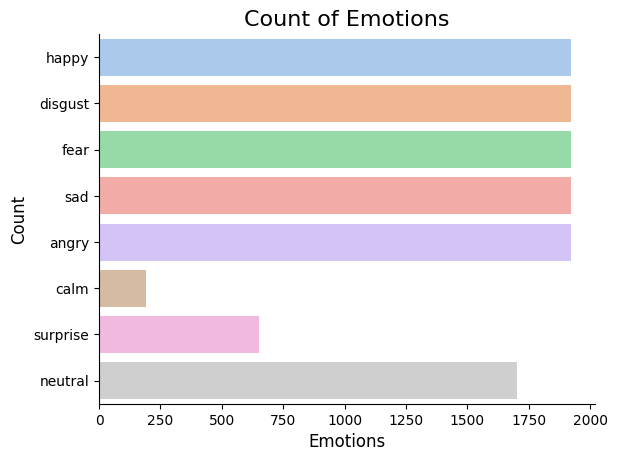

In [40]:
pastel_colors = sns.color_palette("pastel", len(data_path.Emotions.unique()))
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions, palette=pastel_colors)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [41]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

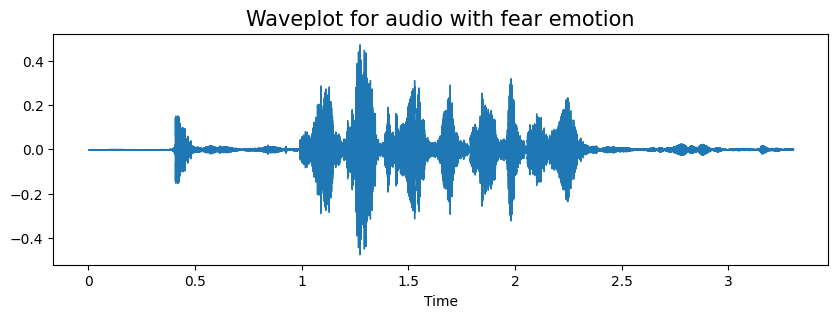

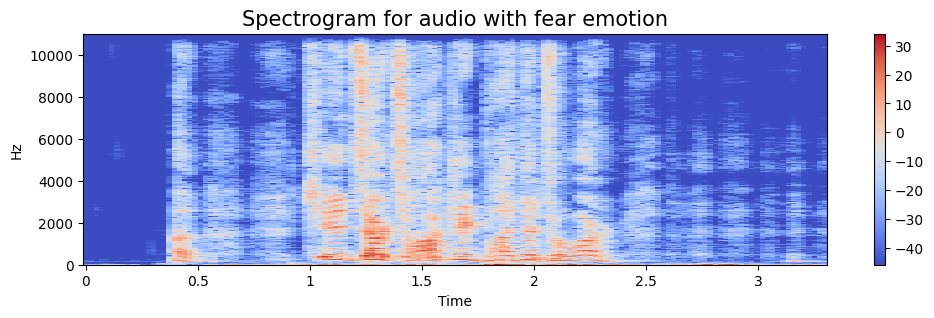

In [42]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

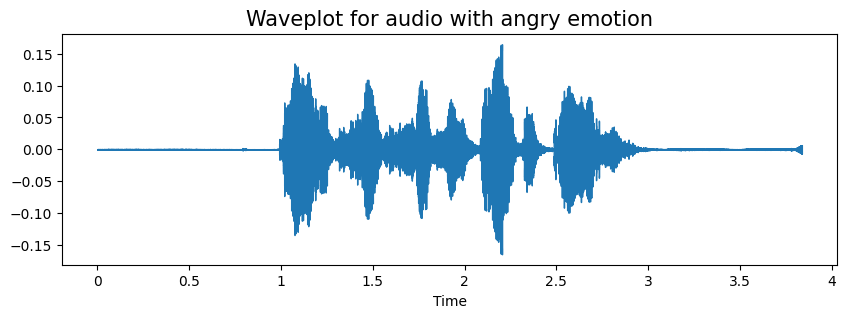

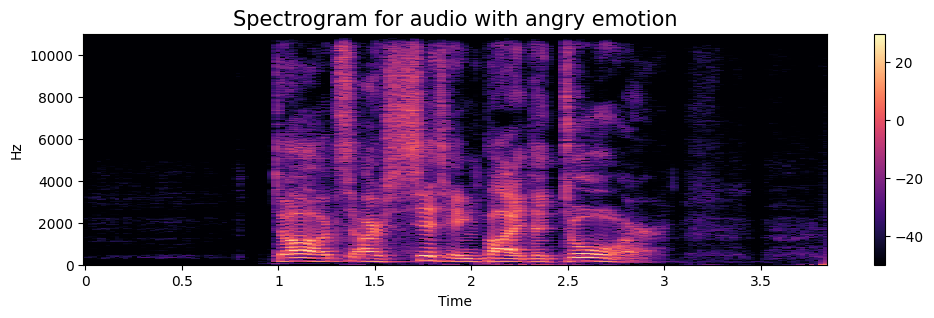

In [43]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

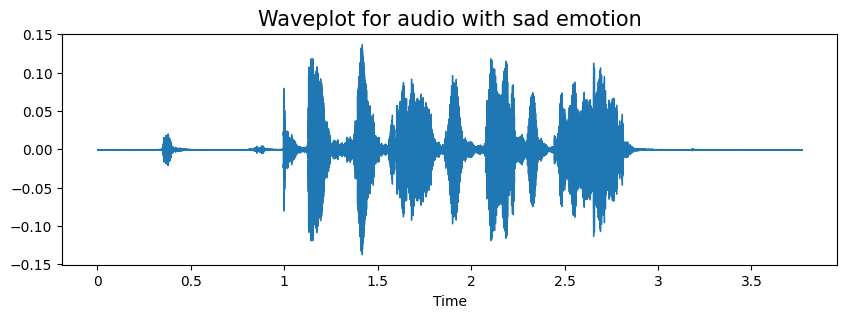

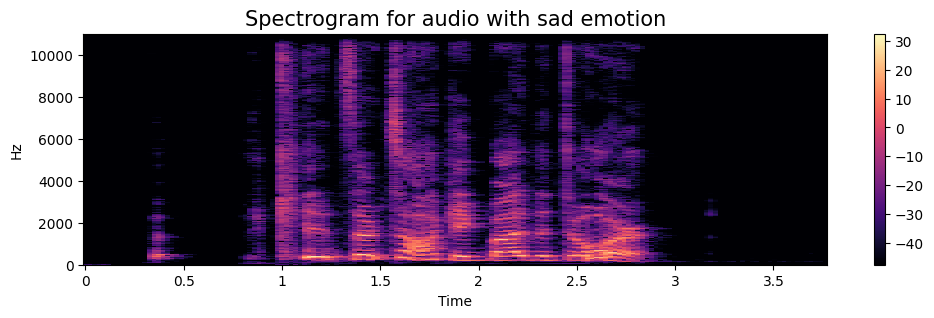

In [44]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

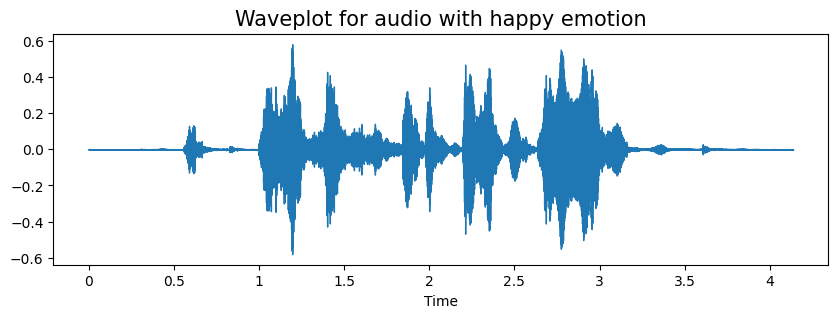

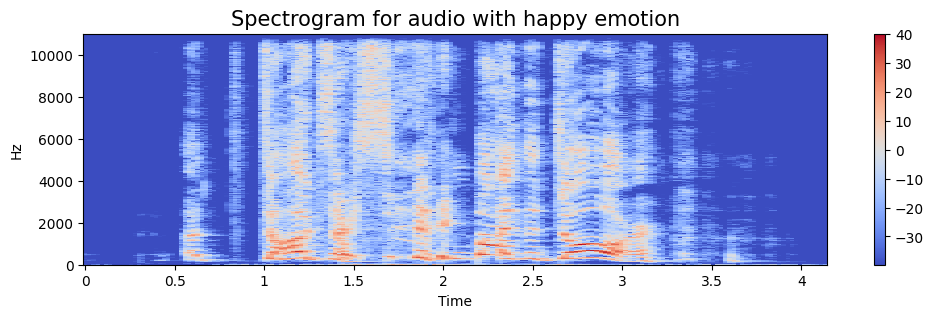

In [45]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [46]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [63]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

1. Simple Audio

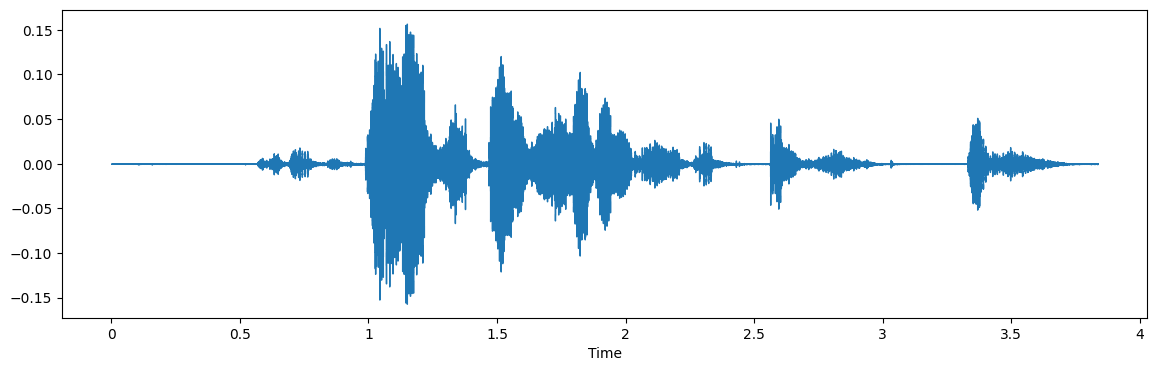

In [65]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

2. Noise Injection:

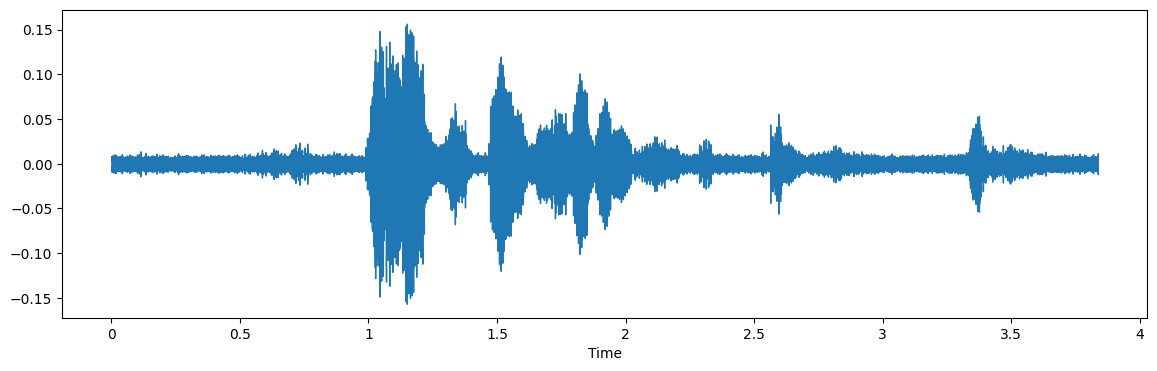

In [67]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

3. Stretching:

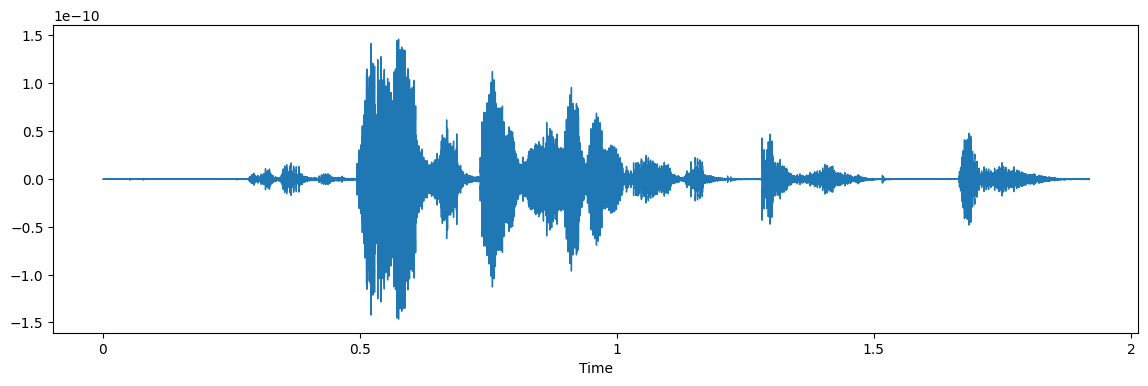

In [73]:
from pydub import AudioSegment


# Assuming data is a NumPy array containing the audio samples
data = data  # your NumPy array

# Convert integer array to floating-point array
data = data / (2 ** 15)  # Assuming 16-bit integer audio

# Create an AudioSegment object from the NumPy array
audio_segment = AudioSegment(
    data=data.tobytes(),
    frame_rate=44100,  # adjust the frame rate as needed
    sample_width=2,  # adjust the sample width as needed
    channels=2  # adjust the number of channels as needed
)

# Now you can use the audio_segment object for further processing

sample_rate = 44100  # adjust the sample rate as needed

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)  # Use the floating-point array 'data'
plt.show()

# If you want to play the audio, you can use the Audio class from IPython
Audio(data, rate=sample_rate)

4. Shifting:

In [73]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5. Pitching:

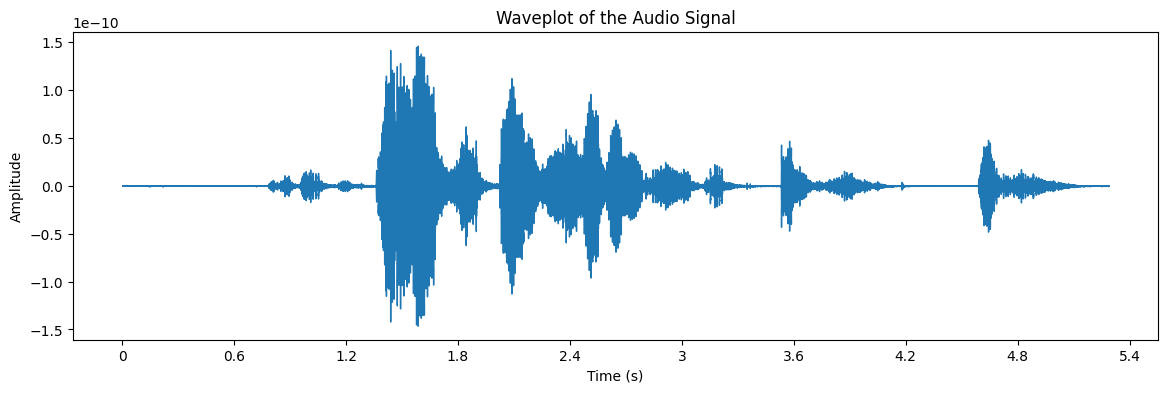

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Assuming `data` contains the audio signal and `sample_rate` is the sample rate.
audio = np.array(data).ravel()  # Ensure audio is a 1D array
sample_rate = 16000  # Replace this with the actual sample rate

# Check if the audio data is valid
if audio.size > 1 and audio.ndim == 1 and audio.dtype.kind in 'bifc' and sample_rate > 0:
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y=audio, sr=sample_rate)
    plt.title('Waveplot of the Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
else:
    print("Audio signal is not valid ")

Audio(audio, rate=sample_rate)


## Feature Extraction

In [47]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
#     data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result

In [49]:
saved_features_filepath = "/kaggle/input/speech-emotion-recognition-output-checkpoint-1/features.csv"
if os.path.exists(saved_features_filepath):
    Features = pd.read_csv(saved_features_filepath)
else:  # Took around 1 hour of computation
    X, Y = [], []
    for path, emotion in zip(data_path.Path, data_path.Emotions):
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(emotion)

    Features = pd.DataFrame(X)
    Features['labels'] = Y
    Features.to_csv('features.csv', index=False)

    len(X), len(Y), data_path.Path.shape
Features.shape

(36486, 163)

## Data Preparation

In [50]:
X = Features.drop('labels', axis=1).values
Y = Features['labels'].values

In [51]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True, stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [53]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [54]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Model Evaluation's Function

In [55]:
def plot_model_accuracy_loss(
    x_test: np.ndarray, y_test: np.ndarray,
    model: Sequential, history: History,
    *,
    epoch_number=50
):
    print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

    epochs = [i for i in range(epoch_number)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

## Model

### CNN

In [56]:
cnn_model=Sequential()
cnn_model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

cnn_model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

cnn_model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=32, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(units=8, activation='softmax'))
cnn_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 21, 128)          

In [57]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=cnn_model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])
cnn_model.save(f"cnn_model.keras")

Epoch 1/50
428/428 [==============================] - 168s 387ms/step - loss: 1.6666 - accuracy: 0.3345 - val_loss: 1.4386 - val_accuracy: 0.4382 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 174s 405ms/step - loss: 1.4320 - accuracy: 0.4264 - val_loss: 1.3230 - val_accuracy: 0.4759 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 184s 430ms/step - loss: 1.3533 - accuracy: 0.4556 - val_loss: 1.2882 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 175s 408ms/step - loss: 1.2949 - accuracy: 0.4774 - val_loss: 1.2444 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 174s 407ms/step - loss: 1.2607 - accuracy: 0.4958 - val_loss: 1.1961 - val_accuracy: 0.5324 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 178s 416ms/step - loss: 1.2324 - accuracy: 0.5047 - val_loss: 1.1875 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 7/50
428/428 [==========================

286/286 [==============================] - 13s 46ms/step - loss: 1.1187 - accuracy: 0.6103
Accuracy of our model on test data :  61.0282838344574 %


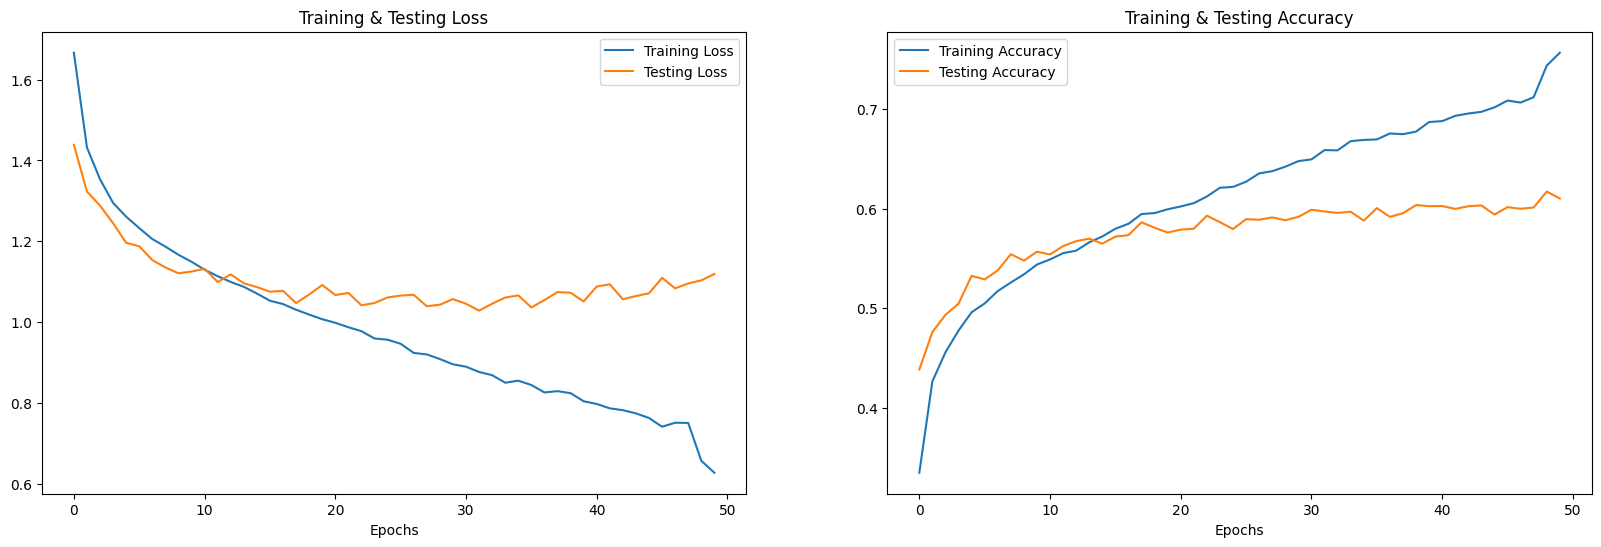

In [58]:
plot_model_accuracy_loss(
    x_test=x_test, y_test=y_test,
    model=cnn_model, history=history,
    epoch_number=50,
)

In [59]:
pred_test = cnn_model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 24s 83ms/step


In [60]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

Predicted Labels Actual Labels
0              sad          fear
1          disgust       disgust
2         surprise      surprise
3          neutral       neutral
4             fear          fear
5            angry         angry
6             fear         happy
7          disgust         happy
8            happy         happy
9            happy       disgust

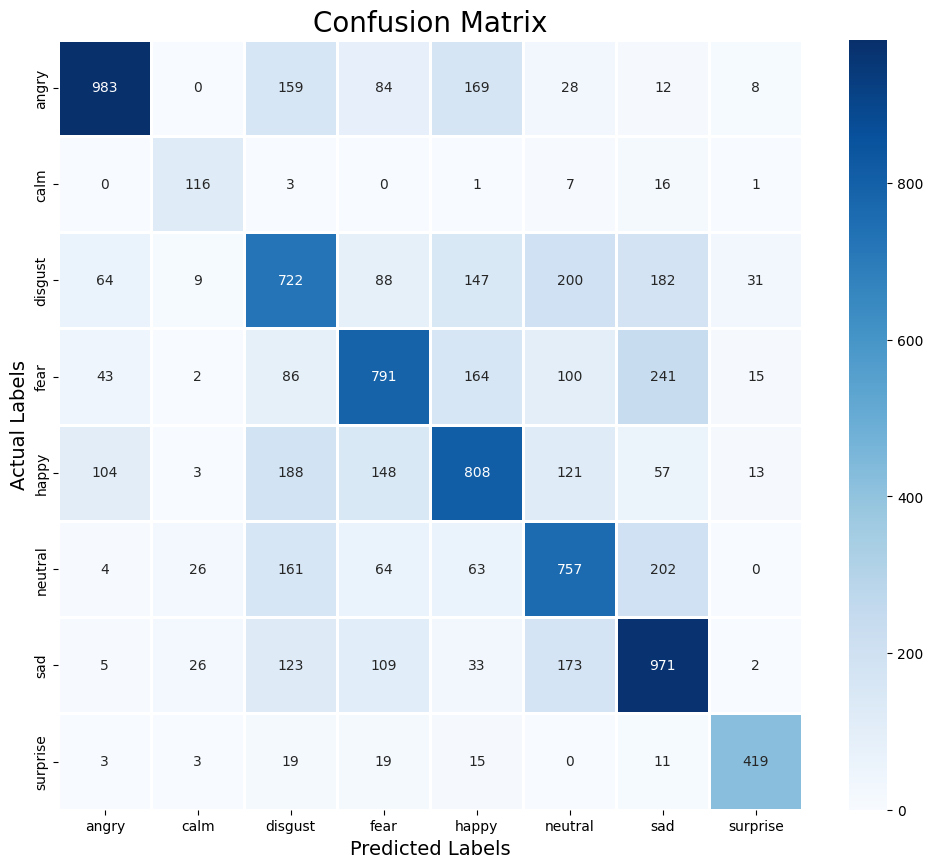

In [61]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.82      0.68      0.74      1443
        calm       0.63      0.81      0.71       144
     disgust       0.49      0.50      0.50      1443
        fear       0.61      0.55      0.58      1442
       happy       0.58      0.56      0.57      1442
     neutral       0.55      0.59      0.57      1277
         sad       0.57      0.67      0.62      1442
    surprise       0.86      0.86      0.86       489

    accuracy                           0.61      9122
   macro avg       0.64      0.65      0.64      9122
weighted avg       0.62      0.61      0.61      9122

